In [1]:
import FinanceDataReader as fdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def getCloseData(ticker, start, end=None):
    """
    종가 데이터
    ticker: 종목 번호
    start: 시작일
    end: 마지막 날짜
    return: 종목의 종가 데이터
    """
    return fdr.DataReader(ticker, start, end)['Close']

def getDayReturn(closeDataSet):
    """
    개별종목 일별 수익률
    closeDataSet: 종가 데이터
    return: 종가 데이터의 일별 수익률
    """
    return (closeDataSet / closeDataSet.shift(1)).fillna(1)

def getCumulativeReturn(closeDataSet=None):
    """
    개별종목 누적수익률 == 자산흐름
    closeDataSet: 종가 데이터
    return:종가데이터 누적수익률
    """
    return closeDataSet / closeDataSet.iloc[0]

def getPortfolioResult(closeDataSet, weight=None):
    """
    포트폴리오 결과
    closeDataSet: 종가 데이터
    weight: 포트폴리오 개별자산 비중
    return: 포트폴리오 일간수익률, 누적수익률
    """
    # 개별종목 일별 수익률
    dayReturn = getDayReturn(closeDataSet)
    # 개별종목 누적 수익률
    cumulativeReturn = getCumulativeReturn(closeDataSet)
    # 자산별 비중. 기본값: 동일비중
    if not weight:
        weight = [1/len(closeDataSet.columns)] * len(closeDataSet.columns)
        
    # 포트폴리오 누적 수익률
    portfolioCumulativeReturn = (weight * cumulativeReturn).sum(axis=1)
    # 포트폴리오 일별 수익률
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1)
        
#     # 자산별 비중이 반영된 개별자산 누적 수익률
#     weightedCumulativeReturn = weight * cumulativeReturn
#     # 자산흐름 정규화: 시기별 각 자산 보유 비율
#     normalizedAssetFlow = weightedCumulativeReturn.divide(weightedCumulativeReturn.sum(axis=1), axis=0) # 각 행의 합으로 각 행을 나누기
#     # 자산별 비중이 반영된 개별자산 일별 수익률
#     weightedDayReturn = normalizedAssetFlow * dayReturn.shift(-1).fillna(0)
#     # 포트폴리오 일별 수익률 = 자산별 비중이 반영된 개별자산 일별 수익률의 합
#     portfolioDayReturn = weightedDayReturn.sum(axis=1).shift(1).fillna(1)
#     # 포트폴리오 누적 수익률
#     portfolioCumulativeReturn = portfolioDayReturn.cumprod()
# #     portfolioCumulativeReturn = weightedCumulativeReturn.sum(axis=1)
    
    return portfolioDayReturn, portfolioCumulativeReturn

def getEvaluation(cumulativeReturn):
    """
    cagr, dd, mdd
    투자 성과 지표
    """
    # cagr
    cagr = cumulativeReturn.iloc[-1] ** (252/len(cumulativeReturn))
    # mdd
    dd = (cumulativeReturn.cummax() - cumulativeReturn) / cumulativeReturn.cummax() * 100
    mdd= dd.max()
    
    print(f"cagr: {cagr}\nmdd: {mdd}")

    return cagr, dd, mdd

def getRebalancingDate(closeDataSet, period="month"):
    """
    리밸런싱 일자 추출
    월별, 분기별, 연별
    """
    data = closeDataSet.copy()
    data = pd.DataFrame(data)
    data.index = pd.to_datetime(data.index)
    data['year'] = data.index.year
    data['month'] = data.index.month
    
    if period == "month":
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
        
    if period == "quarter":
        # 3 6 9 12월 말에 리밸런싱
        # np where 같은걸로 3, 6, 9, 12월 데이터만 가져오고
        # drop_duplicates keep last 하면 됌
        quarter = [3,6,9,12]
        data = data.loc[data['month'].isin(quarter)]
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
    
    if period == "year":
        rebalancingDate = data.drop_duplicates(['year'], keep="last").index
        
    return rebalancingDate

def getRebalancingPortfolioResult(closeDataSet, period = "month", weightDf=None):
    """
    리밸런싱 포트폴리오 결과
    closeDataSet: 종가 데이터
    weight: 포트폴리오 개별자산 비중
    return: 포트폴리오 일간수익률, 누적수익률
    """
    
    rebalancingDate = getRebalancingDate(closeDataSet, period) # 리밸런싱 날짜
    
    # 자산별 비중. 기본값: 동일비중
    if weightDf is None:
        weightDf = pd.DataFrame([[1/len(closeDataSet.columns)] * len(closeDataSet.columns)] * len(rebalancingDate),
                              index=rebalancingDate,
                              columns=closeDataSet.columns)
      
    portfolio = pd.DataFrame() # 빈 데이터 프레임 생성

    totalAsset = 1 # 총 자산, 초기값 1
    start = rebalancingDate[0] # 리밸런싱 날짜, 초기값 첫 투자일

    for end in rebalancingDate[1:]:
        weight = weightDf.loc[start] # 당월 리밸런싱 비율
        priceData = closeDataSet.loc[start:end] # 당월 가격 데이터
        cumReturn = getCumulativeReturn(priceData) # 당월 누적 수익률
        weightedCumReturn = weight * cumReturn # 당월 리밸런싱 비율이 반영된 누적 수익률
        netCumReturn = totalAsset * weightedCumReturn # 전월 투자 결과 반영

        start = end # start 갱신
        totalAsset = netCumReturn.iloc[-1].sum() # 총 자산 갱신
        portfolio = pd.concat([portfolio, netCumReturn]) # 매월 데이터 추가
    
    portfolio = portfolio.loc[~portfolio.index.duplicated(keep='last')] # 중복 데이터 제거
    portfolioCumulativeReturn = portfolio.sum(axis=1) # 포트폴리오 누적 수익률
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1) # 포트폴리오 일간 수익률
    
    return portfolioDayReturn, portfolioCumulativeReturn

## 리밸런싱


#### 리밸런싱 개념  

In [3]:
dummyData =pd.DataFrame(
    {
        "stock": [10, 5] * 5,
        "bond": [5, 10] * 5,
    },
)
dummyData

,stock,bond
0,10,5
1,5,10
2,10,5
3,5,10
4,10,5
5,5,10
6,10,5
7,5,10
8,10,5
9,5,10


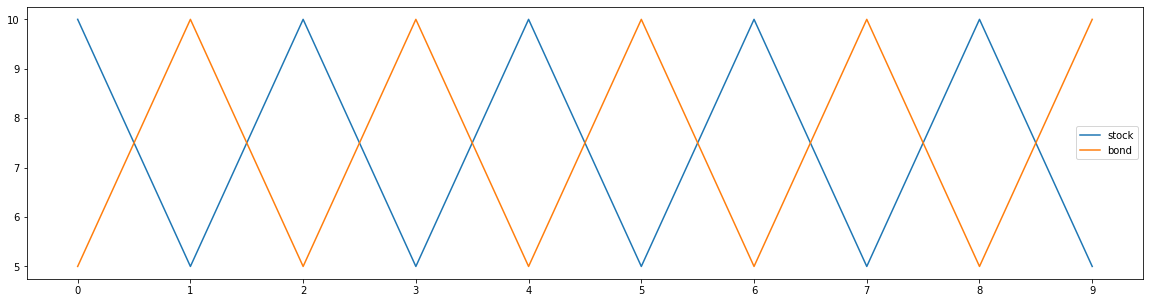

In [4]:
dummyData.plot(figsize=(20,5))
plt.xticks(dummyData.index)
plt.show()

지금까지는 사고 그대로 존버하는 포지션이었지만,  
이번엔 **매월 말 주식:현금 = 1:1 비율로 조절해주는 리밸런싱 기법**을 도입해보겠습니다.  

#### 리밸런싱 코드 구현하기

In [5]:
closeDataSet = pd.DataFrame(
    {
        "kodex200": [100, 140, 120, 110, 100, 120, 110, 115, 120],
        "kodex10Bond": [100, 90, 105, 115, 125, 130, 120, 125, 130],
    },
    index=pd.to_datetime(["2022-01-31", "2022-02-10", "2022-02-21", "2022-02-28", "2022-03-10", "2022-03-19", "2022-03-31", "2022-04-20", "2022-04-30",])
)
closeDataSet

,kodex200,kodex10Bond
2022-01-31,100,100
2022-02-10,140,90
2022-02-21,120,105
2022-02-28,110,115
2022-03-10,100,125
2022-03-19,120,130
2022-03-31,110,120
2022-04-20,115,125
2022-04-30,120,130


In [6]:
# 리밸런싱 날짜 가져오기
# 매달 마지막 영업일

closeDataSet['year'] = closeDataSet.index.year
closeDataSet['month'] = closeDataSet.index.month
rebalancingDate = closeDataSet.drop_duplicates(['year','month'], keep="last").index
closeDataSet.drop(['year', 'month'], axis=1, inplace=True)
rebalancingDate

DatetimeIndex(['2022-01-31', '2022-02-28', '2022-03-31', '2022-04-30'], dtype='datetime64[ns]', freq=None)

In [7]:
# 월별 리밸런싱 비중
# 나중엔 이걸 베이스로 모멘텀 비중으로 해도 되고,,커스텀 가능
defaultWeight = [1/len(closeDataSet.columns)] * len(closeDataSet.columns)
MonthlyWeight = pd.DataFrame([defaultWeight] * len(rebalancingDate), index=rebalancingDate, columns=closeDataSet.columns) 
MonthlyWeight

,kodex200,kodex10Bond
2022-01-31,0.5,0.5
2022-02-28,0.5,0.5
2022-03-31,0.5,0.5
2022-04-30,0.5,0.5


### 1. 누적수익률을 이용하는 방법

In [8]:
# 월별 누적 수익률을 구하기

start = rebalancingDate[0] # 리밸런싱 날짜, 초기값 첫 투자일

for end in rebalancingDate[1:]:
    weight = MonthlyWeight.loc[start] # 당월 리밸런싱 비율
    priceData = closeDataSet.loc[start:end] # 당월 가격 데이터
    cumReturn = getCumulativeReturn(priceData) # 당월 누적 수익률
    weightedCumReturn = weight * cumReturn # 당월 리밸런싱 비율이 반영된 누적 수익률
    
    
    start = end # start 갱신
    
    print(weightedCumReturn)

            kodex200  kodex10Bond
2022-01-31      0.50        0.500
2022-02-10      0.70        0.450
2022-02-21      0.60        0.525
2022-02-28      0.55        0.575
            kodex200  kodex10Bond
2022-02-28  0.500000     0.500000
2022-03-10  0.454545     0.543478
2022-03-19  0.545455     0.565217
2022-03-31  0.500000     0.521739
            kodex200  kodex10Bond
2022-03-31  0.500000     0.500000
2022-04-20  0.522727     0.520833
2022-04-30  0.545455     0.541667


**월별 투자 결과가 그 다음달에도 연속적으로 반영되어야 합니다.**

In [9]:
# 투자 결과 연속 반영

totalAsset = 1 # 총 자산, 초기값 1
start = rebalancingDate[0] # 리밸런싱 날짜, 초기값 첫 투자일

for end in rebalancingDate[1:]:
    weight = MonthlyWeight.loc[start] # 당월 리밸런싱 비율
    priceData = closeDataSet.loc[start:end] # 당월 가격 데이터
    cumReturn = getCumulativeReturn(priceData) # 당월 누적 수익률
    weightedCumReturn = weight * cumReturn # 당월 리밸런싱 비율이 반영된 누적 수익률
    netCumReturn = totalAsset * weightedCumReturn # 전월 투자 결과 반영
    
    
    start = end # start 갱신
    print("갱신 전 총 자산: ",totalAsset)
    totalAsset = netCumReturn.iloc[-1].sum() # 총 자산 갱신
    print(netCumReturn)
    print("갱신 후 총 자산: ",totalAsset)

갱신 전 총 자산:  1
            kodex200  kodex10Bond
2022-01-31      0.50        0.500
2022-02-10      0.70        0.450
2022-02-21      0.60        0.525
2022-02-28      0.55        0.575
갱신 후 총 자산:  1.125
갱신 전 총 자산:  1.125
            kodex200  kodex10Bond
2022-02-28  0.562500     0.562500
2022-03-10  0.511364     0.611413
2022-03-19  0.613636     0.635870
2022-03-31  0.562500     0.586957
갱신 후 총 자산:  1.1494565217391304
갱신 전 총 자산:  1.1494565217391304
            kodex200  kodex10Bond
2022-03-31  0.574728     0.574728
2022-04-20  0.600852     0.598675
2022-04-30  0.626976     0.622622
갱신 후 총 자산:  1.2495985671936758


**위 결과를 하나의 데이터 프레임으로 합쳐서 전체 포트폴리오의 누적 수익률을 계산 할 수 있습니다.**

In [10]:
# 하나의 데이터 프레임으로 합치기

portfolio = pd.DataFrame() # 빈 데이터 프레임 생성

totalAsset = 1 # 총 자산, 초기값 1
start = rebalancingDate[0] # 리밸런싱 날짜, 초기값 첫 투자일

for end in rebalancingDate[1:]:
    weight = MonthlyWeight.loc[start] # 당월 리밸런싱 비율
    priceData = closeDataSet.loc[start:end] # 당월 가격 데이터
    cumReturn = getCumulativeReturn(priceData) # 당월 누적 수익률
    weightedCumReturn = weight * cumReturn # 당월 리밸런싱 비율이 반영된 누적 수익률
    netCumReturn = totalAsset * weightedCumReturn # 전월 투자 결과 반영
    
    
    start = end # start 갱신
    totalAsset = netCumReturn.iloc[-1].sum() # 총 자산 갱신
    portfolio = pd.concat([portfolio, netCumReturn]) # 매월 데이터 추가

portfolio    

,kodex200,kodex10Bond
2022-01-31,0.500000,0.500000
2022-02-10,0.700000,0.450000
2022-02-21,0.600000,0.525000
2022-02-28,0.550000,0.575000
2022-02-28,0.562500,0.562500
2022-03-10,0.511364,0.611413
2022-03-19,0.613636,0.635870
2022-03-31,0.562500,0.586957
2022-03-31,0.574728,0.574728
2022-04-20,0.600852,0.598675


**매달 중복되는 데이터를 제거하고, 최종 포트폴리오 누적 수익률을 계산합니다.**

In [11]:
portfolio.index.duplicated(keep='last')

array([False, False, False,  True, False, False, False,  True, False,
       False, False])

In [12]:
portfolio.loc[~portfolio.index.duplicated(keep='last')]

,kodex200,kodex10Bond
2022-01-31,0.500000,0.500000
2022-02-10,0.700000,0.450000
2022-02-21,0.600000,0.525000
2022-02-28,0.562500,0.562500
2022-03-10,0.511364,0.611413
2022-03-19,0.613636,0.635870
2022-03-31,0.574728,0.574728
2022-04-20,0.600852,0.598675
2022-04-30,0.626976,0.622622


In [13]:
portfolio = portfolio.loc[~portfolio.index.duplicated(keep='last')]

In [14]:
portCumReturn = portfolio.sum(axis=1)
portCumReturn

2022-01-31    1.000000
2022-02-10    1.150000
2022-02-21    1.125000
2022-02-28    1.125000
2022-03-10    1.122777
2022-03-19    1.249506
2022-03-31    1.149457
2022-04-20    1.199528
2022-04-30    1.249599
dtype: float64

### 2. 일간 수익률을 이용하는 방법 (선택사항)

#### 함수화

In [15]:
def getRebalancingDate(closeDataSet, period="month"):
    """
    리밸런싱 일자 추출
    월별, 분기별, 연별
    """
    data = closeDataSet.copy()
    data = pd.DataFrame(data)
    data.index = pd.to_datetime(data.index)
    data['year'] = data.index.year
    data['month'] = data.index.month
    
    if period == "month":
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
        
    if period == "quarter":
        # 3 6 9 12월 말에 리밸런싱
        # np where 같은걸로 3, 6, 9, 12월 데이터만 가져오고
        # drop_duplicates keep last 하면 됌
        quarter = [3,6,9,12]
        data = data.loc[data['month'].isin(quarter)]
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
    
    if period == "year":
        rebalancingDate = data.drop_duplicates(['year'], keep="last").index
        
    return rebalancingDate

In [16]:
def getRebalancingPortfolioResult(closeDataSet, period = "month", weightDf=None):
    """
    리밸런싱 포트폴리오 결과
    closeDataSet: 종가 데이터
    weight: 포트폴리오 개별자산 비중
    return: 포트폴리오 일간수익률, 누적수익률
    """
    
    rebalancingDate = getRebalancingDate(closeDataSet, period) # 리밸런싱 날짜
    
    # 자산별 비중. 기본값: 동일비중
    if weightDf is None:
        weightDf = pd.DataFrame([[1/len(closeDataSet.columns)] * len(closeDataSet.columns)] * len(rebalancingDate),
                              index=rebalancingDate,
                              columns=closeDataSet.columns)
      
    portfolio = pd.DataFrame() # 빈 데이터 프레임 생성

    totalAsset = 1 # 총 자산, 초기값 1
    start = rebalancingDate[0] # 리밸런싱 날짜, 초기값 첫 투자일

    for end in rebalancingDate[1:]:
        weight = weightDf.loc[start] # 당월 리밸런싱 비율
        priceData = closeDataSet.loc[start:end] # 당월 가격 데이터
        cumReturn = getCumulativeReturn(priceData) # 당월 누적 수익률
        weightedCumReturn = weight * cumReturn # 당월 리밸런싱 비율이 반영된 누적 수익률
        netCumReturn = totalAsset * weightedCumReturn # 전월 투자 결과 반영

        start = end # start 갱신
        totalAsset = netCumReturn.iloc[-1].sum() # 총 자산 갱신
        portfolio = pd.concat([portfolio, netCumReturn]) # 매월 데이터 추가
    
    portfolio = portfolio.loc[~portfolio.index.duplicated(keep='last')] # 중복 데이터 제거
    portfolioCumulativeReturn = portfolio.sum(axis=1) # 포트폴리오 누적 수익률
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1) # 포트폴리오 일간 수익률
    
    return portfolioDayReturn, portfolioCumulativeReturn

#### 실전 데이터 적용

In [17]:
# 데이터 로드
kodex200 = getCloseData("069500", "2002") # 코스피200 ETF
kodex10Bond = getCloseData("152380", "2002") # kodex 국고채 10년물 etf

# kodex200 = 069500
# kodex10Bond = 152380
# S&P500 = SPY
# 미국 7-10 국채 = IEF

closeDataSet = pd.concat([kodex200, kodex10Bond], axis=1)
closeDataSet.columns = ['kodex200', 'kodex10Bond']
closeDataSet.dropna(inplace=True)
rebalancingDate = getRebalancingDate(closeDataSet)
closeDataSet = closeDataSet.loc[rebalancingDate[0]:]
closeDataSet

,kodex200,kodex10Bond
Date,,
2012-01-31,21792,50180.0
2012-02-01,21819,50230.0
2012-02-02,22064,50180.0
2012-02-03,21952,50190.0
2012-02-06,21984,50120.0
...,...,...
2022-06-09,34565,62800.0
2022-06-10,34210,62740.0
2022-06-13,33000,62055.0


In [18]:
weight= pd.DataFrame([[0.6, 0.4]] * len(closeDataSet), index=closeDataSet.index, columns=closeDataSet.columns) 

In [19]:
rebalPortfolioDayReturn, rebalPortfolioCumulativeReturn = getRebalancingPortfolioResult(closeDataSet)

In [20]:
rebalancingDate = getRebalancingDate(closeDataSet)

In [21]:
portfolioDayReturn, portfolioCumulativeReturn = getPortfolioResult(closeDataSet.loc[rebalancingDate[0]:])

#### 전략 성과 비교

In [22]:
print("리밸런싱 포트폴리오 누적 수익률")
print(rebalPortfolioCumulativeReturn.iloc[-1])

rebalCagr, rebalDD, rebalMDD = getEvaluation(rebalPortfolioCumulativeReturn)

리밸런싱 포트폴리오 누적 수익률
1.3870277386448475
cagr: 1.032807455950748
mdd: 19.112630808582185


In [23]:
print("Buy & Hold 포트폴리오 누적 수익률")
print(portfolioCumulativeReturn.iloc[-1])
cagr, dd, mdd = getEvaluation(portfolioCumulativeReturn)


Buy & Hold 포트폴리오 누적 수익률
1.3512058589810896
cagr: 1.030144455965315
mdd: 20.00351165620869


In [24]:
stockDayReturn = getDayReturn(kodex200.loc[rebalancingDate[0]:])
stockCumReturn = getCumulativeReturn(kodex200.loc[rebalancingDate[0]:])

print("주식 100% 포트폴리오 누적 수익률")
print(stockCumReturn.iloc[-1])
cagr, dd, mdd = getEvaluation(stockCumReturn)

주식 100% 포트폴리오 누적 수익률
1.4815069750367107
cagr: 1.0395445875700338
mdd: 38.08322008671455


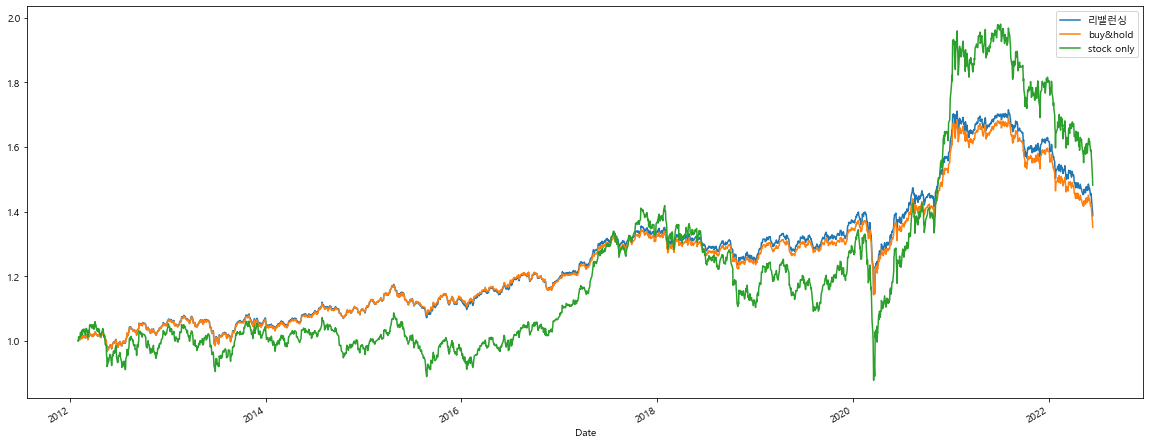

In [25]:
plt.rc('font', family='malgun gothic')
plt.figure(figsize=(20,8))
rebalPortfolioCumulativeReturn.plot(label="리밸런싱")
portfolioCumulativeReturn.plot(label="buy&hold")
stockCumReturn.plot(label="stock only")
plt.legend()
plt.show()

정리: 2021까지는 단순히 주식에 100% 올인하는 것보다. 채권과 혼합하여 포트폴리오를 구성하면 훨씬 더 안정적이고 수익률도 높게 만들 수 있었다.  
하지만, 이번 포트폴리오는 채권과 주식이 어떤 상황에서든 절반으로 나누어져 있기 때문에,(그리고 채권 가격이 커플링) 2021년 주식 가파른 상승장이 왔을 때는 그 추세를 누리지 못했다.  
장세를 반영하여 포트폴리오 비율을 조절할 필요가 있다. -> 추세 개념과 모멘텀